Detect anomalies in time-series data related to the cryogenic chamber, using an LSTM autoencoder.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [3]:
sns.set(style="whitegrid")

Load the Preprocessed (Scaled) Data

In [4]:
df_scaled = pd.read_csv('cryogenic_chamber_data_scaled.csv', parse_dates=['timestamp'])
df_scaled.sort_values('timestamp', inplace=True)
df_scaled.reset_index(drop=True, inplace=True)

In [5]:
feature_cols = ['chamber_temp_K', 'chamber_pressure_bar', 'external_temp_K', 'power_input']
print("Data shape:", df_scaled.shape)
print("Features:", feature_cols)

Data shape: (2000, 5)
Features: ['chamber_temp_K', 'chamber_pressure_bar', 'external_temp_K', 'power_input']


### Prepare Time-Series Sequences for Autoencoder

In [7]:
'''
In an autoencoder approach for time-series, we often do: 
X_train = X_test = (the same input sequences),
with the target also being the same sequence (i.e., we reconstruct the input).
'''

'\nIn an autoencoder approach for time-series, we often do: \nX_train = X_test = (the same input sequences),\nwith the target also being the same sequence (i.e., we reconstruct the input).\n'

In [8]:
TIME_STEPS = 10

In [9]:
def create_sequences(data, time_steps=1):
    """Convert 2D array into a 3D array (samples, time_steps, features) 
       for time-series autoencoder training."""
    seqs = []
    for i in range(len(data) - time_steps + 1):
        seq = data[i:(i+time_steps)]
        seqs.append(seq)
    return np.array(seqs)

In [10]:
data_array = df_scaled[feature_cols].values
X = create_sequences(data_array, TIME_STEPS)

Train the autoencoder on the first 80% of sequences (assumed "normal"), then we can test anomaly detection on the entire set or the remaining portion.

In [11]:
train_size = int(X.shape[0] * 0.8)
X_train = X[:train_size]

In [12]:
X_test = X  # We'll detect anomalies in the entire dataset to see how it performs

### Build LSTM Autoencoder
### The autoencoder architecture:
- LSTM encoder compresses the time-series data
- LSTM decoder reconstructs the original time-series

In [13]:
latent_dim = 32  # dimension of the encoded representation

In [14]:
model_ae = Sequential([
    layers.Input(shape=(TIME_STEPS, len(feature_cols))),
    # Encoder
    layers.LSTM(64, activation='relu', return_sequences=True),
    layers.LSTM(latent_dim, activation='relu', return_sequences=False),
    # Decoder
    layers.RepeatVector(TIME_STEPS),
    layers.LSTM(latent_dim, activation='relu', return_sequences=True),
    layers.LSTM(64, activation='relu', return_sequences=True),
    layers.TimeDistributed(layers.Dense(len(feature_cols)))
])

In [15]:
model_ae.compile(optimizer='adam', loss='mse')
model_ae.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 64)         │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 10, 32)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 10, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 10, 4)          │           260 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,492 (248.02 KB)

 Trainable params: 63,492 (248.02 KB)

 Non-trainable params: 0 (0.00 B)

### Train the Autoencoder

In [17]:
EPOCHS = 20
BATCH_SIZE = 32

In [18]:
history_ae = model_ae.fit(
    X_train, X_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    shuffle=True
)

Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.1712 - val_loss: 0.0665
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0425 - val_loss: 0.0141
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0114 - val_loss: 0.0103
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0090 - val_loss: 0.0097
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0083 - val_loss: 0.0093
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0082 - val_loss: 0.0092
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0081 - val_loss: 0.0089
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0078 - val_loss: 0.0087
Epoch 9/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0077 - val_loss: 0.0089
Epoch 10/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0076 - val_loss: 0.0086
Epoch 11/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0076 - val_loss: 0.0087
Epoch 12/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0076 - 

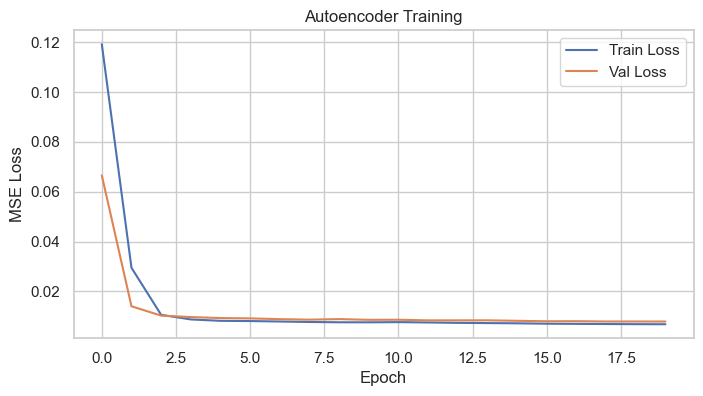

In [19]:
plt.figure(figsize=(8,4))
plt.plot(history_ae.history['loss'], label='Train Loss')
plt.plot(history_ae.history['val_loss'], label='Val Loss')
plt.title('Autoencoder Training')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

### Reconstruction on Test Data

In [21]:
X_test_pred = model_ae.predict(X_test)

# The shape of X_test_pred should match X_test: (samples, TIME_STEPS, features)
print("Pred shape:", X_test_pred.shape, " | Test shape:", X_test.shape)

# MSE reconstruction errors for each sample
mse_per_sample = []
for i in range(X_test.shape[0]):
    # Flatten across time_steps & features or compute MSE in 2D
    # Typically, MSE is done over all time steps & features
    mse_value = mean_squared_error(
        X_test[i].flatten(), 
        X_test_pred[i].flatten()
    )
    mse_per_sample.append(mse_value)

mse_per_sample = np.array(mse_per_sample)
print("MSE array shape:", mse_per_sample.shape)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step   
Pred shape: (1991, 10, 4)  | Test shape: (1991, 10, 4)
MSE array shape: (1991,)


### Define an Anomaly Threshold

#### We'll define a threshold based on the training set's reconstruction error distribution.

In [22]:
X_train_pred = model_ae.predict(X_train)
mse_train = []
for i in range(X_train.shape[0]):
    mse_train.append(mean_squared_error(X_train[i].flatten(), X_train_pred[i].flatten()))
mse_train = np.array(mse_train)

# A common simplistic approach: threshold = mean + 3 * std of training errors
mean_mse = np.mean(mse_train)
std_mse = np.std(mse_train)
threshold = mean_mse + 3 * std_mse

print(f"Training MSE mean: {mean_mse:.6f}, std: {std_mse:.6f}")
print(f"Anomaly threshold: {threshold:.6f}")

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training MSE mean: 0.006926, std: 0.002664
Anomaly threshold: 0.014919


### Flag Anomalies in the Entire Dataset

In [23]:
anomalies = mse_per_sample > threshold

# DataFrame to store the anomaly status along with the final timestamp in each sequence
df_anomaly = pd.DataFrame({
    'sequence_end_idx': np.arange(TIME_STEPS-1, TIME_STEPS-1 + len(mse_per_sample)),
    'recon_error': mse_per_sample,
    'is_anomaly': anomalies
})

# Merge with the original timestamps for clarity
df_anomaly['timestamp'] = df_scaled.loc[df_anomaly['sequence_end_idx'], 'timestamp'].values

print(df_anomaly.head(15))

    sequence_end_idx  recon_error  is_anomaly           timestamp
0                  9     0.004523       False 2025-01-01 02:15:00
1                 10     0.004395       False 2025-01-01 02:30:00
2                 11     0.004479       False 2025-01-01 02:45:00
3                 12     0.004307       False 2025-01-01 03:00:00
4                 13     0.005156       False 2025-01-01 03:15:00
5                 14     0.005298       False 2025-01-01 03:30:00
6                 15     0.005170       False 2025-01-01 03:45:00
7                 16     0.006101       False 2025-01-01 04:00:00
8                 17     0.005247       False 2025-01-01 04:15:00
9                 18     0.004551       False 2025-01-01 04:30:00
10                19     0.004192       False 2025-01-01 04:45:00
11                20     0.004618       False 2025-01-01 05:00:00
12                21     0.004321       False 2025-01-01 05:15:00
13                22     0.007021       False 2025-01-01 05:30:00
14        

### Visualise Anomalies

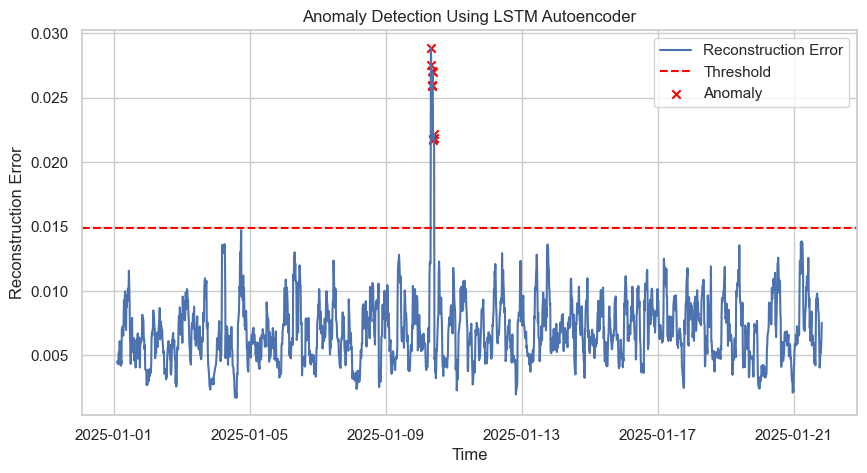

In [25]:
plt.figure(figsize=(10,5))
plt.plot(df_anomaly['timestamp'], df_anomaly['recon_error'], label='Reconstruction Error')
plt.axhline(y=threshold, color='red', linestyle='--', label='Threshold')
plt.scatter(df_anomaly.loc[df_anomaly['is_anomaly'], 'timestamp'],
            df_anomaly.loc[df_anomaly['is_anomaly'], 'recon_error'],
            color='red', marker='x', label='Anomaly')
plt.title("Anomaly Detection Using LSTM Autoencoder")
plt.xlabel("Time")
plt.ylabel("Reconstruction Error")
plt.legend()
plt.show()

### Save Model & Results

In [26]:
model_ae.save('cryogenic_autoencoder.h5')
df_anomaly.to_csv('anomaly_detection_results.csv', index=False)
print("\nAnomaly detection model saved as 'cryogenic_autoencoder.h5'.")
print("Detection results saved in 'anomaly_detection_results.csv'.\n")


Anomaly detection model saved as 'cryogenic_autoencoder.h5'.
Detection results saved in 'anomaly_detection_results.csv'.



### Interpreting Results

In [28]:
print("""How to interpret:
- 'recon_error' measures how well the autoencoder reconstructed the original sequence.
- Higher errors may indicate unusual system states that differ from the normal patterns
  learned during training.
- 'is_anomaly' flags True if 'recon_error' > threshold.
- Threshold is arbitrary or based on domain expertise.
""")

How to interpret:
- 'recon_error' measures how well the autoencoder reconstructed the original sequence.
- Higher errors may indicate unusual system states that differ from the normal patterns
  learned during training.
- 'is_anomaly' flags True if 'recon_error' > threshold.
- Threshold is arbitrary or based on domain expertise.

